# Semantic segmentation with backbone

In [1]:
!pip install segmentation-models --quiet
!pip install mycolorpy --quiet
!pip install tensorflow-addons --quiet
!pip install -U albumentations>=0.3.0 --quiet
!pip install opencv-python==4.1.2.30
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/M_DV_V2022

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/M_DV_V2022


In [2]:
!pip uninstall opencv-python-headless==4.5.5.62 --quiet
!pip install opencv-python-headless==4.5.2.52 --quiet

Proceed (y/n)? y


In [3]:
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [4]:
import matplotlib.pyplot as plt
import numpy as np
#from cv2 import Sobel, Laplacian, watershed
#import cv2 as cv
import seaborn as sns
import pandas as pd

import albumentations as A

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mycolorpy import colorlist as mcp


#from PIL import Image

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input
from keras.callbacks import EarlyStopping
import tensorflow_addons as tfa

from keras.layers import Input, Conv2D
from keras.models import Model


import tensorflow as tf
from tensorflow.keras import backend as K
from unet_detection.models.vanilla_unet import vanilla_unet

# Load data

In [198]:
X_train_raw = np.load("data/spec_lib/X_data.npy") 
y_train_raw = np.load("data/spec_lib/y_data.npy")

#X_val = np.load("data/spec_lib/X_data_val.npy")
#y_val = np.load("data/spec_lib/y_data_val.npy")

X_test_raw = np.load("data/spec_lib/X_data_test.npy")
y_test_raw = np.load("data/spec_lib/y_data_test.npy")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


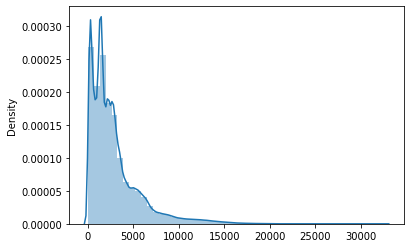

In [196]:
sns.distplot(abs(X_train_raw[0]))

In [12]:
rød = X_train[:,:,:,81]; grønn = X_train[:,:,:,46]; blå = X_train[:,:,:,21];
rgb = [np.dstack((r,g,b)) for r,g,b in zip(rød,grønn,blå)]
rgb = np.array(rgb)

u1,u2 = arange_image(rgb, o=0), arange_image(rgb, o=48)

rød = X_test[:,:,:,81]; grønn = X_test[:,:,:,46]; blå = X_test[:,:,:,21];
rgb = [np.dstack((r,g,b)) for r,g,b in zip(rød,grønn,blå)]
rgb = np.array(rgb)

w1,w2 = arange_image(rgb, nx=6, ny=2, o=0), arange_image(rgb, nx=6, ny=2, o=12)

def set_grid(ax, nx=8, ny=6):
  ax.set_yticks([j*128 for j in range(0,ny+1)])
  ax.set_xticks([j*128 for j in range(0,nx+1)])
  ax.grid(color='w', linestyle='--', linewidth=0.9)

#fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

for u, nx, title in zip([u1,u2,w1,w2], 
                        [8,8,2,2], 
                        ["Train set 1", "Train set 2", "Test set 1", "Test set 2"]):
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
  ax.imshow(u/2500)
  set_grid(ax, nx)
  ax.set_title(title)




#for ax, u, ny in zip(axs, [u1,u2,w1,w2], [8,8,2,2]):
#  ax.imshow(u/2500)
#  set_grid(ax, ny)

#plt.imshow(u1/2500)

NameError: ignored

In [199]:
# test mange ganger på dist, så fordel :)
def train_val_split(X, y, val_split=0.2, idx=None):
  # Check if possible to stride
  assert np.unique(y).shape[0] == 11, "not enough unique values in set to stride" # n classes / Kanskje ta med det?

  # Do it
  dist = []
  for y_ in y:
    a = list(np.unique(y_, return_counts=True))
    for i in range(11):
      if i not in a[0]:
        a[0] = np.append(a[0], i)
        a[1] = np.append(a[1], 0)

    a[0], a[1] = zip(*sorted(zip(a[0], a[1])))
    dist.append(a)

  dist = np.array(dist, dtype=object)
  data_length = np.array([i for i in range(X.shape[0])])
  val_split = int(X.shape[0]*val_split)

  switch_test = False
  if idx is None:
    for _ in range(100):
      idx = np.random.choice(data_length, replace=False, size=val_split)
      e = np.sum(dist[idx], axis=0)[1]
      test = np.any((e == 0))
      if not test:
        print(test, e, idx)
        # ok in test set?
        switch_test = True
        break
    
    assert switch_test == True, "Not found any good strides"
  X_val = X[idx]
  y_val = y[idx]

  not_idx = np.array(data_length[list(set(range(X.shape[0])) - set(idx))])
  X_train = X[not_idx]
  y_train = y[not_idx]

  a = np.unique(y_val ,return_counts=True)[1]
  b = np.unique(y_train ,return_counts=True)[1]
  try: 
    c = np.abs(a/np.sum(a) - b/np.sum(b))
  except:
    c = np.array([1,1])
  

  t = (c < 0.01).all()
  print(c)
  

  return X_train, X_val, y_train, y_val, t

In [200]:
X_train, X_val, y_train, y_val, t = train_val_split(X_train_raw, y_train_raw, val_split=0.2,
                                                    idx=np.array([94, 26, 69, 34 ,75, 83, 5, 40 , 7, 60 , 8, 20, 92, 55, 78, 85, 63, 65 ,80]))




[0.00187636 0.00686426 0.00647528 0.00963287 0.0039017  0.005261
 0.00908493 0.00473175 0.00108315 0.00122083 0.00335385]


In [201]:
t=False

In [202]:
y_train.shape
np.unique(y_train, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int32),
 array([1072578,   74249,   34272,    8832,    8034,    2072,   38237,
           6014,    1057,    5686,   10537]))

In [63]:
np.unique(y_val, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int32),
 array([264078,  20458,   6441,   5178,   3197,   2149,   6607,     11,
           598,   1023,   1556]))

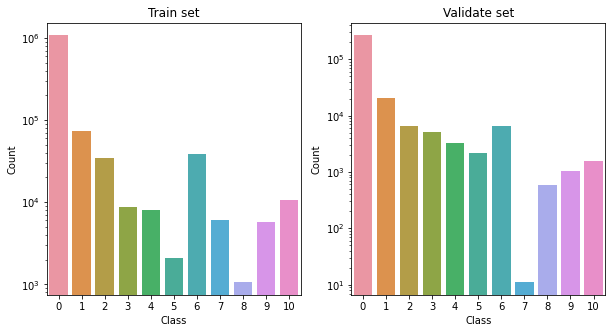

In [153]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
sns.reset_orig()

for ax, y, title in [(ax1, y_train, "Train set"), (ax2, y_val, "Validate set")]:
  dist = np.array(np.unique(y, return_counts=True))
  a = pd.DataFrame(dist.T, columns = ["Class", "Count"])
  a["label"] = ["None", "unknown", "black concrete", "metal roofing", "black ceramic", "brown concrete", 
            "red concrete", "gravel", "green ceramic", "pcv", "tar roofing paper"]
  sns.reset_orig()
  g= sns.barplot(data=a, x="Class", y="Count", ax=ax)
  ax.set_title(title)
  g.set_yscale("log")

In [62]:
# Binært
#y_train[y_train > 0] = 1
#y_val[y_val > 0] = 1
#y_test_raw[y_test_raw > 0] = 1

In [176]:
def redesign_y(y):
  y = y.reshape((y.shape[0],y.shape[1], y.shape[2], 1))
  n,r1,c1,d = y.shape
  # Adds a new dimension of layer too have two class problem.
  yy = np.append(y, np.zeros((n, r1, c1,d)), axis=3)
  for i in range(int(y.max()-1)):  
    yy = np.append(yy, np.zeros((n, r1, c1,d)), axis=3)
  #yy[yy >= 0.001] = 1
  yy1 = yy.copy()
  yy1[:,:,:,0] = 0 # reset map
  for i in range(n):
    values = yy[i,:,:,0]
    for r in range(r1):
      for c in range(c1):
        value = yy[i,r,c,0]
        yy1[i,r,c,int(value)] = 1

  return yy1

In [203]:
X_test = X_test_raw.copy()

maksen = 20000
X_train[X_train>maksen] = maksen
X_val[X_val>maksen] = maksen
X_test[X_test>maksen] = maksen

X_train /= maksen
X_val /= maksen
X_test /= maksen

In [204]:
y_train = redesign_y(y_train)
y_val = redesign_y(y_val)
y_test = redesign_y(y_test_raw)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(77, 128, 128, 11)
(19, 128, 128, 11)
(24, 128, 128, 11)


# Dimension reduction - PCA

In [13]:
from sklearn.decomposition import PCA

In [14]:
pca = PCA(n_components=10)
X_train[:,:,:,:-1].reshape(X_train.shape[0]*X_train.shape[1]*X_train.shape[2],
                                   X_train.shape[3]-1).shape

pca.fit(X_train[:,:,:,:-1].reshape(X_train.shape[0]*
                                   X_train.shape[1]*X_train.shape[2],
                                   X_train.shape[3]-1))



PCA(n_components=10)

In [15]:
def mypca(X,y):
  ndsm = X[:,:,:,-1]
  hs = X[:,:,:,:-1]

  hs_pca = pca.transform(hs.reshape(hs.shape[0]*hs.shape[1]*hs.shape[2], 
                                    hs.shape[3])).reshape(hs.shape[0], hs.shape[1], hs.shape[2], 10)
  ndsm = ndsm.reshape(ndsm.shape[0], ndsm.shape[1], ndsm.shape[2], 1)
  hs_pca = np.append(hs_pca, ndsm, axis=3)
  return hs_pca

In [16]:
X_train = mypca(X_train, None)
X_val = mypca(X_val, None)
X_test = mypca(X_test, None)

In [45]:
X_test.shape

(24, 128, 128, 11)

# Pick out some wavelenghts

In [55]:
idx = np.append(np.arange(0,399,step=3), 398)

X_train = X_train[:,:,:,idx]
X_val = X_val[:,:,:,idx]
X_test = X_test[:,:,:,idx]

In [56]:
X_train.shape

(150, 128, 128, 134)

# Bring togheter wavelenghts

In [70]:
idx = np.arange(0,398,step=10)

def mean_waves(X_data):
  ndsm = X_data[:,:,:,-1]
  hs = X_data[:,:,:,:-1]

  X = None
  for i in idx:
    if i+10 > 398:
      i = 398 - 10
    if X is not None:
      temp = np.mean(hs[:,:,:,i:i+10], axis=3)
      temp = temp.reshape(temp.shape[0], temp.shape[1], temp.shape[2], 1)
      X = np.append(X, temp, axis=3)
      pass
    else:
      X = np.mean(hs[:,:,:,i:i+10], axis=3)
      X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

  ndsm = ndsm.reshape(ndsm.shape[0], ndsm.shape[1], ndsm.shape[2], 1)
  X = np.append(X, ndsm, axis=3)

  return X

In [71]:
X_train = mean_waves(X_train)
X_val = mean_waves(X_val)
X_test = mean_waves(X_test)

In [72]:
X_train.shape

(150, 128, 128, 41)

# Augmentation of Xtrain data

In [236]:
transforms = A.Compose([
            A.Perspective(p=1),
            A.OneOf(
                          [
                              A.RandomBrightnessContrast(p=1),
                              A.RandomGamma(p=1),
                          ],
                          p=0.9,
                      ),

                      A.OneOf(
                          [
                              A.Sharpen(p=1),
                              A.Blur(blur_limit=3, p=1),
                              A.MotionBlur(blur_limit=3, p=1),
                          ],
                          p=0.9,
                      )
                  ])


#augmented = aug(image=X_train[0], mask=y_train[0])




In [239]:
def aug_fn(image, img_size):
    data = {"image":image}
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    aug_img = tf.cast(aug_img, tf.float32)
    aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
    return aug_img

In [240]:
def process_data(image, label, img_size):
    aug_img = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.float32)
    return aug_img, label

In [241]:
from functools import partial


In [242]:
# create dataset
data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
AUTOTUNE = tf.data.experimental.AUTOTUNE

ds_alb = data.map(partial(process_data, img_size=120),
                  num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
ds_alb

<PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 11), dtype=tf.float64, name=None))>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


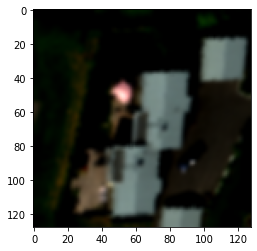

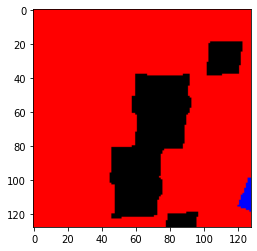

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


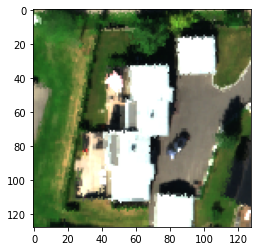

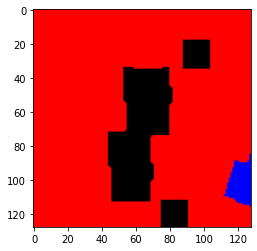

In [214]:
rød = augmented["image"][:,:,81]
grønn =augmented["image"][:,:,46]
blå = augmented["image"][:,:,21]
#rgb = [np.dstack((r,g,b)) for r,g,b in zip(rød,grønn,blå)]
rgb = np.dstack([rød,grønn,blå])
rgb = np.array(rgb)

plt.imshow(rgb*4)
plt.show()
plt.imshow(augmented["mask"][:,:,0:3])
plt.show()



rød = X_train[0,:,:,81]
grønn =X_train[0,:,:,46]
blå = X_train[0,:,:,21]
#rgb = [np.dstack((r,g,b)) for r,g,b in zip(rød,grønn,blå)]
rgb = np.dstack([rød,grønn,blå])
rgb = np.array(rgb*4)
plt.imshow(rgb*2)
plt.show()
plt.imshow(y_train[0,:,:,0:3])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


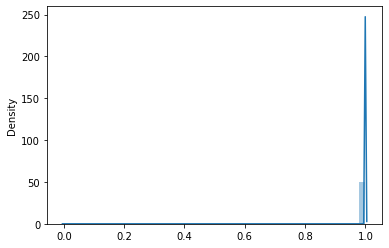

In [188]:
sns.distplot(X_train[0])

In [126]:
rød.shape

(77, 128)

# Set up metrics/loss

In [227]:
def multi_mcc_loss(y_true, y_pred, false_pos_penal=1.0):
    # Reshape image to flatten form
    y_true = K.reshape(y_true, [-1, y_true.shape[-1]])
    y_pred = K.reshape(y_pred, [-1, y_pred.shape[-1]])

    confusion_m = tf.matmul(K.transpose(y_true), y_pred)
    if false_pos_penal != 1.0:
      """
      This part is done for penalization of FalsePos symmetrically with FalseNeg,
      i.e. FalseNeg is favorized for the same factor. In such way MCC values are comparable.
      If you want to penalize FalseNeg, than just set false_pos_penal < 1.0 ;)
      """
      confusion_m = tf.linalg.band_part(confusion_m, 0, 0) + tf.linalg.band_part(confusion_m, 0, -1)*false_pos_penal + tf.linalg.band_part(confusion_m, -1, 0)/false_pos_penal
    
    N = K.sum(confusion_m)
    
    up = N*tf.linalg.trace(confusion_m) - K.sum(tf.matmul(confusion_m, confusion_m))
    down_left = K.sqrt(N**2 - K.sum(tf.matmul(confusion_m, K.transpose(confusion_m))))
    down_right = K.sqrt(N**2 - K.sum(tf.matmul(K.transpose(confusion_m), confusion_m)))
    
    mcc = up / (down_left * down_right + K.epsilon())
    mcc = tf.where(tf.math.is_nan(mcc), tf.zeros_like(mcc), mcc)
    
    return 1 - K.mean(mcc)

def multi_mcc(y_true, y_pred, false_pos_penal=1.0):
    # Reshape image to flatten form
    #y_true = tf.convert_to_tensor(y_true)
    #y_pred = tf.convert_to_tensor(y_pred)
    y_true = K.reshape(y_true, [-1, y_true.shape[-1]])
    y_pred = K.reshape(y_pred, [-1, y_pred.shape[-1]])

    confusion_m = tf.matmul(K.transpose(y_true), y_pred)
    if false_pos_penal != 1.0:
      """
      This part is done for penalization of FalsePos symmetrically with FalseNeg,
      i.e. FalseNeg is favorized for the same factor. In such way MCC values are comparable.
      If you want to penalize FalseNeg, than just set false_pos_penal < 1.0 ;)
      """
      confusion_m = tf.linalg.band_part(confusion_m, 0, 0) + tf.linalg.band_part(confusion_m, 0, -1)*false_pos_penal + tf.linalg.band_part(confusion_m, -1, 0)/false_pos_penal
    
    N = K.sum(confusion_m)
    up = N*tf.linalg.trace(confusion_m) - K.sum(tf.matmul(confusion_m, confusion_m))
    down_left = K.sqrt(N**2 - K.sum(tf.matmul(confusion_m, K.transpose(confusion_m))))
    down_right = K.sqrt(N**2 - K.sum(tf.matmul(K.transpose(confusion_m), confusion_m))) 
    
    mcc = up / (down_left * down_right + K.epsilon())
    mcc = tf.where(tf.math.is_nan(mcc), tf.zeros_like(mcc), mcc)
    return K.mean(mcc)


# Set up model

In [243]:
#base_model = sm.Unet(backbone_name='resnet34', encoder_weights='imagenet',
#                     classes=11, activation='softmax', encoder_freeze=True)

#inp = Input(shape=(128, 128, 399))
#l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
#out = base_model(l1)

#model = Model(inp, out, name=base_model.name)

model = sm.Unet(backbone_name='resnet34', encoder_weights=None, input_shape=(128, 128, X_train.shape[-1]),
                classes=11, activation='softmax')

In [244]:
#u = vanilla_unet()
#inp = Input(shape=(128, 128, 399))
#model = u.get_unet(inp, None, n_classes=11, last_activation="softmax")

In [245]:
from segmentation_models.losses import CategoricalFocalLoss
from sklearn.metrics import matthews_corrcoef
from segmentation_models.losses import JaccardLoss
from segmentation_models.losses import DiceLoss
from segmentation_models.losses import CategoricalCELoss

loss = CategoricalFocalLoss()
j_loss = JaccardLoss(class_weights=np.array([1,1,1,1,1,1,1,1,1,1,1]))
d_loss = DiceLoss()
loss =  loss + 0.5*j_loss
#loss = CategoricalCELoss()

f1 = tfa.metrics.F1Score(num_classes=11, average='micro')
model.compile(optimizer='adam',
                loss=loss,
                metrics=[f1, multi_mcc])

In [246]:
#K.clear_session()

In [247]:
def train(epochs):
  h = model.fit(ds_alb,
            validation_data=(X_val, y_val),
            batch_size=32,
            epochs=epochs, verbose=2)
  return h

h = train(5)
#train(50)
#model.save("model50.h5")
#train(50)
#model.save("model100.h5")
#train(100)
#model.save("model200.h5")
#train(100)
#model.save("model300.h5")

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/functional.py:1136: RuntimeWarning: invalid value encountered in power
  img = np.power(img, gamma)


InvalidArgumentError: ignored

In [14]:
#model50 = model
#model50 = model.copy()
#modell100 - modell200 - model300
model.save("model50.h5")

Text(0.5, 1.0, 'scorings')

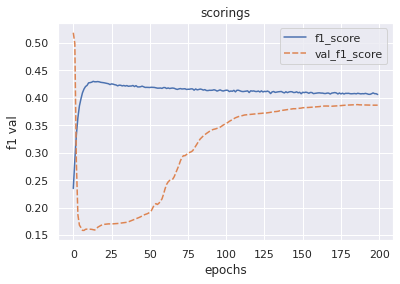

In [74]:
sns.set_theme()
sns.lineplot(data={key:(h.history[key][:]) for key in ['f1_score','val_f1_score']})
plt.xlabel("epochs"); plt.ylabel("f1 val")
plt.title("scorings")

# Show pred data

In [69]:
X_test = X_test_raw
rød = X_test[:,:,:,81]; grønn = X_test[:,:,:,46]; blå = X_test[:,:,:,21];
rgb = [np.dstack((r,g,b)) for r,g,b in zip(rød,grønn,blå)]
rgb = np.array(rgb)

nx = 6
ny = 2

def arange_image(img, nx=6, ny=2, o=0):
  u = []
  o = o
  for i in range(int(nx)):
    b = np.array(img[o])
    o += 1
    for j in range(1,int(ny)):
      b = np.append(b, img[o], axis=1)
      o += 1
                  
    if len(u) == 0:
      u = b
    else:
      u = np.append(u, b, axis=0)
  return u


In [70]:
#import keras

In [71]:
#model.load_weights("model50.h5")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


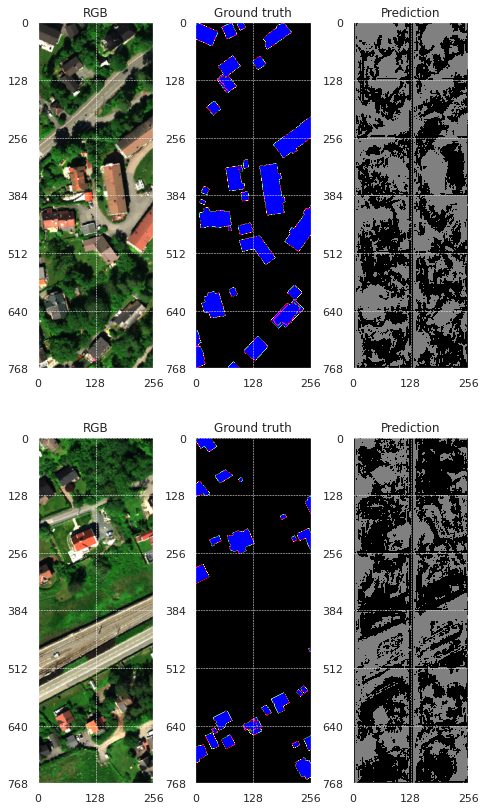

In [72]:
classes = ["None", "Unknown", "black concrete", "metal roofing", "black ceramic", "brown concrete", 
           "red concrete", "gravel", "green ceramic", "pcv", "tar roofing paper"]

colormap = ListedColormap(["black", "gray", "red", "green", "yellow", "cyan", "maroon",
                           "magenta", "seagreen", "purple", "blue"])

y = y_test.argmax(axis=3)

def set_grid(ax):
  ax.set_yticks([j*128 for j in range(0,nx+1)])
  ax.set_xticks([j*128 for j in range(0,ny+1)])
  ax.grid(color='w', linestyle='--', linewidth=0.5)

#sns.set_context(rc={"lines.linewidth": 128})
for name in ["hi"]:
  #model.load_weights(name)
  pred = model.predict(X_test)
  p = np.argmax(pred,axis=3)

  u1,u2 = arange_image(rgb, ny=2, o=0), arange_image(rgb, o=12)
  v1,v2 = arange_image(y,  o=0), arange_image(y,o=12)
  w1,w2 = arange_image(p, o=0), arange_image(p,  o=12)

  w1[0:11, 0] = [0,1,2,3,4,5,6,7,8,9,10]
  w2[0:11, 0] = [0,1,2,3,4,5,6,7,8,9,10]

  #sns.reset_orig()
  fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(8,14))

  for ax,bilde in [(axs[0,0],u1),(axs[1,0],u2)]:
    ax.imshow(bilde/2500); ax.set_title("RGB")
    set_grid(ax)

  for ax,bilde in [(axs[0,1],v1),(axs[1,1],v2)]:
    ax.imshow(bilde, cmap=colormap); ax.set_title("Ground truth")
    set_grid(ax)

  for ax,bilde in [(axs[0,2],w1),(axs[1,2],w2)]:
    im = ax.imshow(bilde, cmap=colormap); ax.set_title("Prediction")
    set_grid(ax)


  #cbar = plt.colorbar(im, cmap=colormap)
  #n_clusters = 11
  #tick_locs = (np.arange(n_clusters) + 0.5)*(n_clusters-1)/n_clusters
  #cbar.set_ticks(tick_locs)
  # set tick labels (as before)
  #cbar.set_ticklabels(classes)

  plt.show()


# Confussion matrix

In [129]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
pred_tot = model.predict(X_val)

[Text(0, 0, 'None'),
 Text(0, 0, 'Unknown'),
 Text(0, 0, 'black ceramic'),
 Text(0, 0, 'black concrete'),
 Text(0, 0, 'brown concrete'),
 Text(0, 0, 'gravel'),
 Text(0, 0, 'green ceramic'),
 Text(0, 0, 'metal roofing'),
 Text(0, 0, 'pcv'),
 Text(0, 0, 'red concrete'),
 Text(0, 0, 'tar roofing paper')]

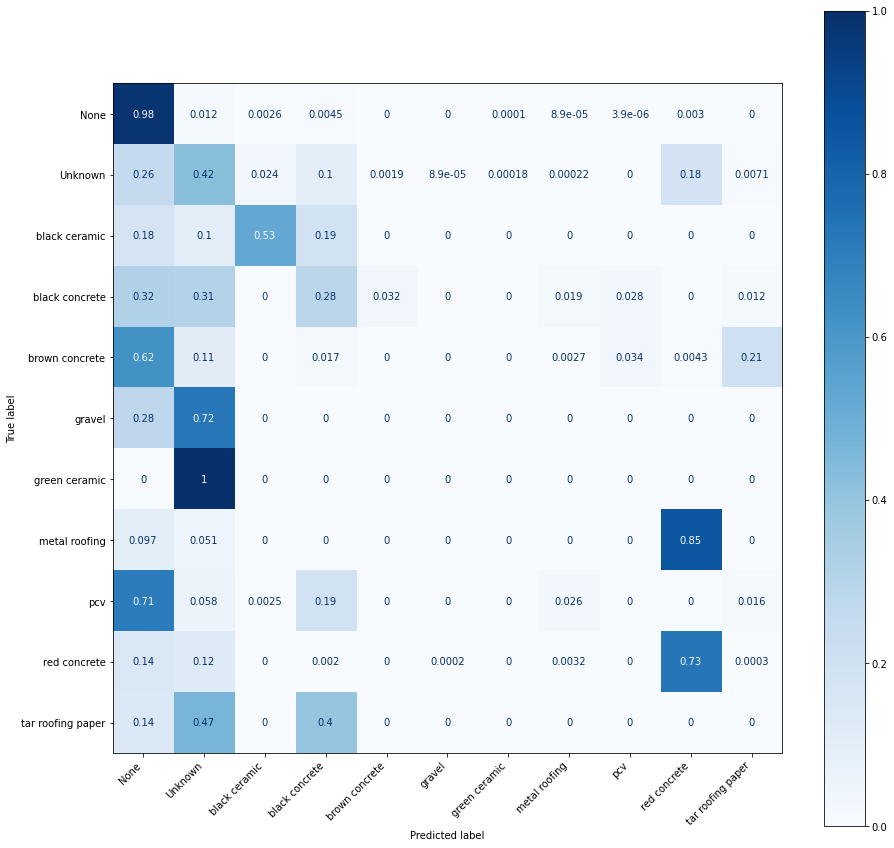

In [130]:
sns.reset_orig()
fig, ax = plt.subplots(figsize=(15, 15))

ticks = np.array(classes)
true = ticks[y_val.argmax(axis=3).flatten()]
pre = ticks[pred_tot.argmax(axis=3).flatten()]


disp = ConfusionMatrixDisplay.from_predictions(true, pre,
                                        labels=np.unique(ticks),
                                        cmap=plt.cm.Blues,
                                        xticks_rotation=45,
                                        ax=ax,
                                        normalize="true")
ax.set_xticklabels(ax.get_xticklabels() ,ha="right")